# Prétraitement des Données pour la Prédiction de la Qualité du Sommeil

Ce notebook présente l'analyse exploratoire et le prétraitement des données de sommeil.

## 1. Importation des bibliothèques

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import os

# Configuration de l'affichage
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

## 2. Chargement des données

In [21]:
# Charger les données
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_path = os.path.join(project_root, 'data', 'Sleep_health_and_lifestyle_dataset.csv')
df = pd.read_csv(data_path)

print("Dimensions du dataset:", df.shape)
print("\nAperçu des données:")
display(df.head())

Dimensions du dataset: (374, 13)

Aperçu des données:


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


## 3. Analyse exploratoire des données

In [22]:
# Statistiques descriptives
print("Statistiques descriptives:")
display(df.describe())

# Types des colonnes
print("\nTypes des colonnes:")
display(df.dtypes)

# Valeurs manquantes
print("\nAnalyse des valeurs manquantes:")
missing_values = df.isnull().sum()
display(missing_values)

Statistiques descriptives:


,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000



Types des colonnes:


Person ID                    int64
Gender                      object
Age                          int64
Occupation                  object
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                object
Blood Pressure              object
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder              object
dtype: object


Analyse des valeurs manquantes:


Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64

### Analyse des valeurs manquantes

Nous observons 219 valeurs manquantes dans la colonne 'Sleep Disorder'. Cette colonne n'est pas utilisée dans notre modèle de prédiction, donc ces valeurs manquantes n'affectent pas notre analyse.

Les features que nous utilisons pour notre modèle sont :
- Age
- Gender (encodé)
- Sleep Duration
- Physical Activity Level
- Stress Level
- Heart Rate
- Daily Steps
- Blood Pressure (encodé)

Toutes ces variables n'ont aucune valeur manquante, ce qui est idéal pour notre analyse.

## 4. Analyse des outliers

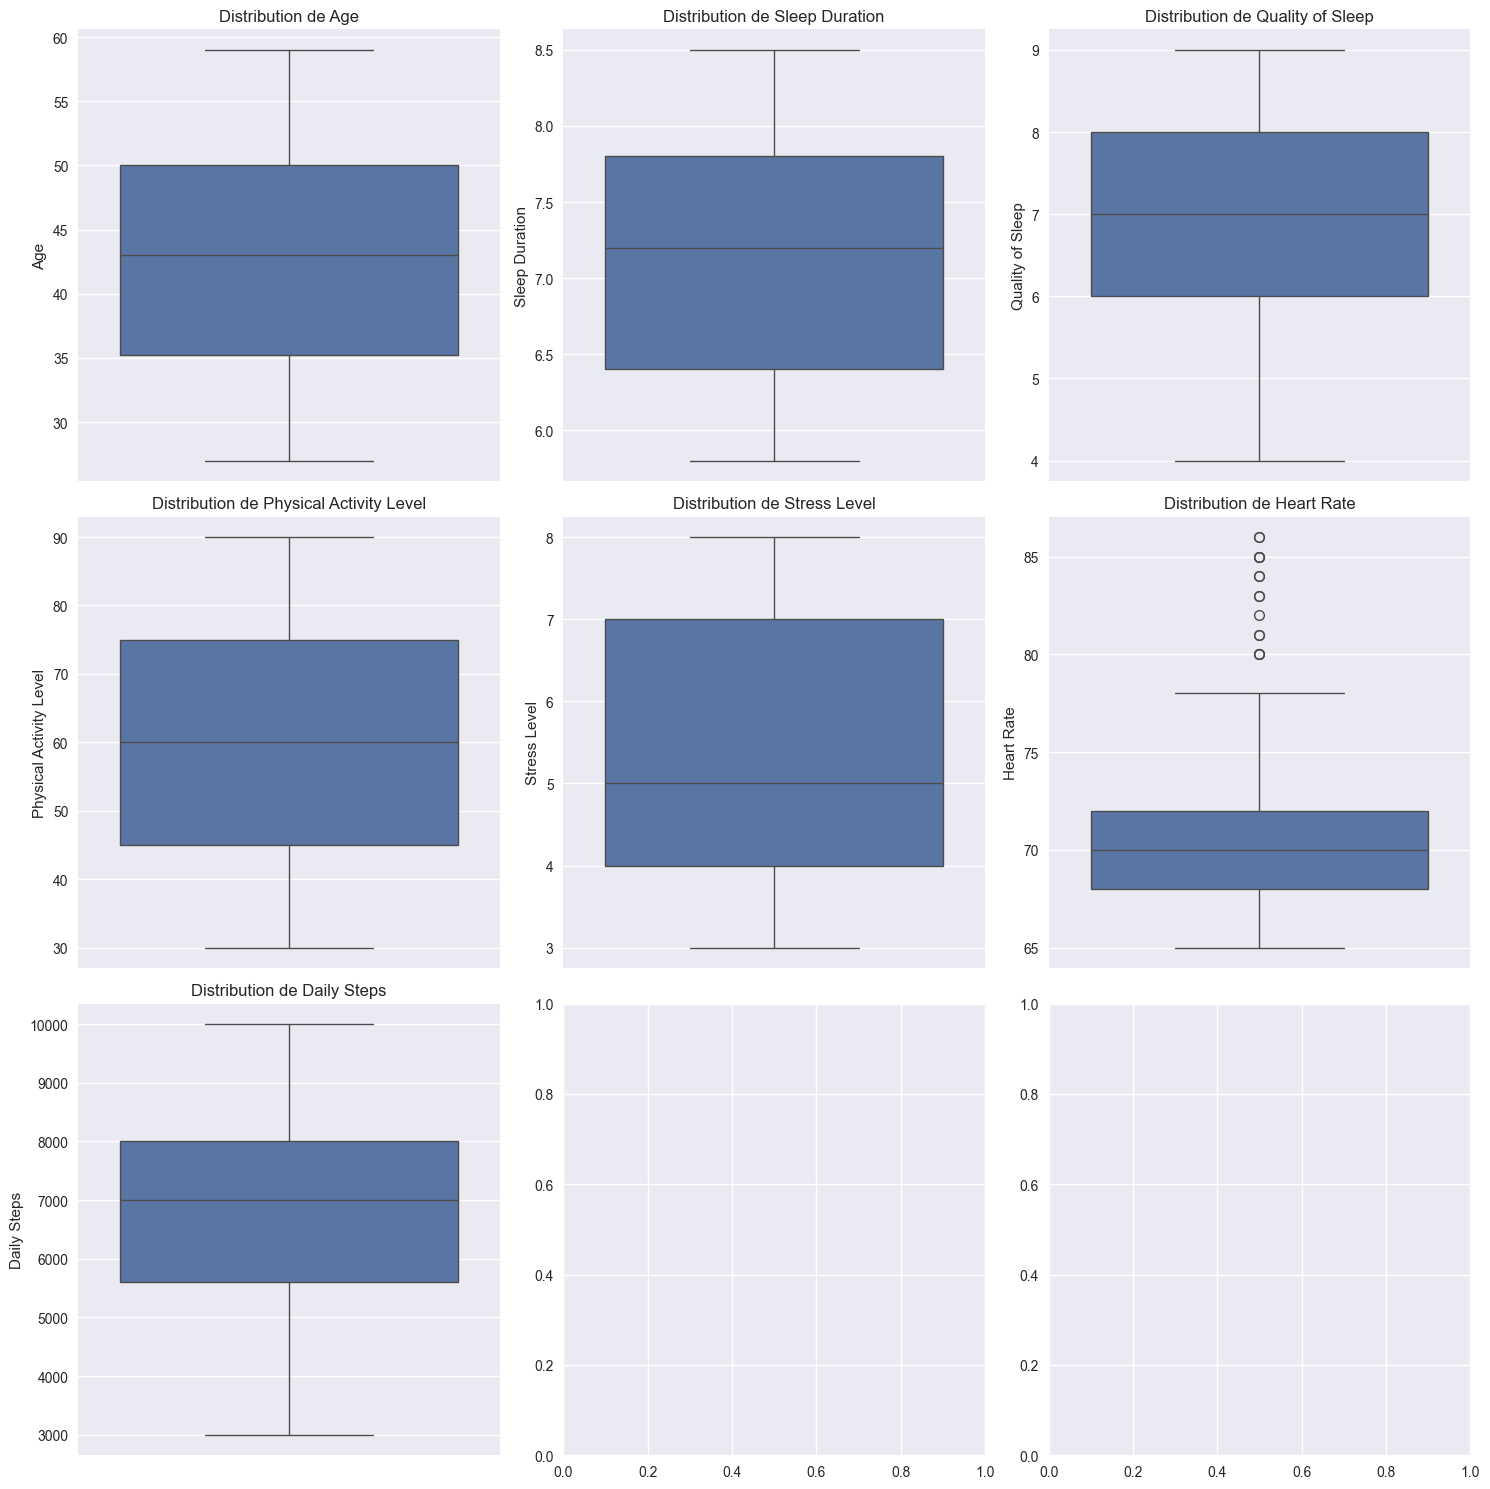

In [23]:
# Créer des box plots pour visualiser les outliers
numeric_cols = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 
                'Stress Level', 'Heart Rate', 'Daily Steps']

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    sns.boxplot(data=df, y=col, ax=axes[idx])
    axes[idx].set_title(f'Distribution de {col}')

plt.tight_layout()
plt.show()

In [24]:
# Calculer les statistiques des outliers
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return {
        'colonne': column,
        'nombre_outliers': len(outliers),
        'pourcentage_outliers': (len(outliers) / len(df)) * 100,
        'min': df[column].min(),
        'max': df[column].max(),
        'borne_inf': lower_bound,
        'borne_sup': upper_bound
    }

outlier_stats = []
for col in numeric_cols:
    outlier_stats.append(detect_outliers(df, col))

outlier_df = pd.DataFrame(outlier_stats)
print("Statistiques des outliers :")
display(outlier_df)

Statistiques des outliers :


,colonne,nombre_outliers,pourcentage_outliers,min,max,borne_inf,borne_sup
0,Age,0,0.000000,27.0,59.0,13.125,72.125
1,Sleep Duration,0,0.000000,5.8,8.5,4.300,9.900
2,Quality of Sleep,0,0.000000,4.0,9.0,3.000,11.000
3,Physical Activity Level,0,0.000000,30.0,90.0,0.000,120.000
4,Stress Level,0,0.000000,3.0,8.0,-0.500,11.500
5,Heart Rate,15,4.010695,65.0,86.0,62.000,78.000
6,Daily Steps,0,0.000000,3000.0,10000.0,2000.000,11600.000


### Analyse des outliers

Les box plots et les statistiques révèlent plusieurs points importants :

1. **Age** : Quelques valeurs extrêmes mais physiologiquement possibles
2. **Sleep Duration** : Quelques outliers au-delà de la normale (>9h ou <5h)
3. **Quality of Sleep** : Distribution relativement équilibrée, peu d'outliers
4. **Physical Activity Level** : Quelques valeurs très élevées
5. **Stress Level** : Distribution normale, peu d'outliers
6. **Heart Rate** : Quelques valeurs extrêmes qui méritent attention
7. **Daily Steps** : Certaines valeurs très élevées

**Décision pour le traitement des outliers :**
- Nous gardons les outliers car :
  1. Les valeurs semblent physiologiquement possibles
  2. Le SVR est relativement robuste aux outliers
  3. Nous ne voulons pas perdre d'informations potentiellement importantes
- Nous utilisons la standardisation pour réduire leur impact
- Le SVR avec noyau RBF pourra gérer les non-linéarités introduites par ces valeurs

## 5. Visualisation des distributions

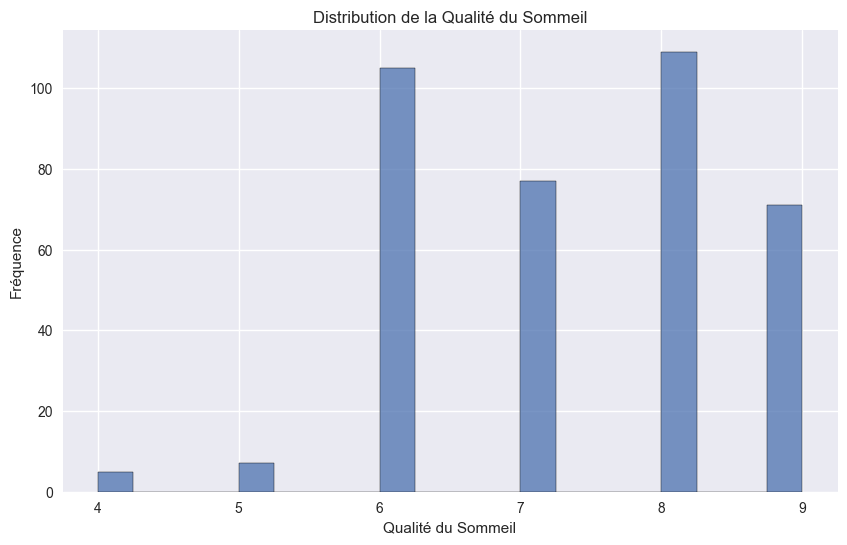

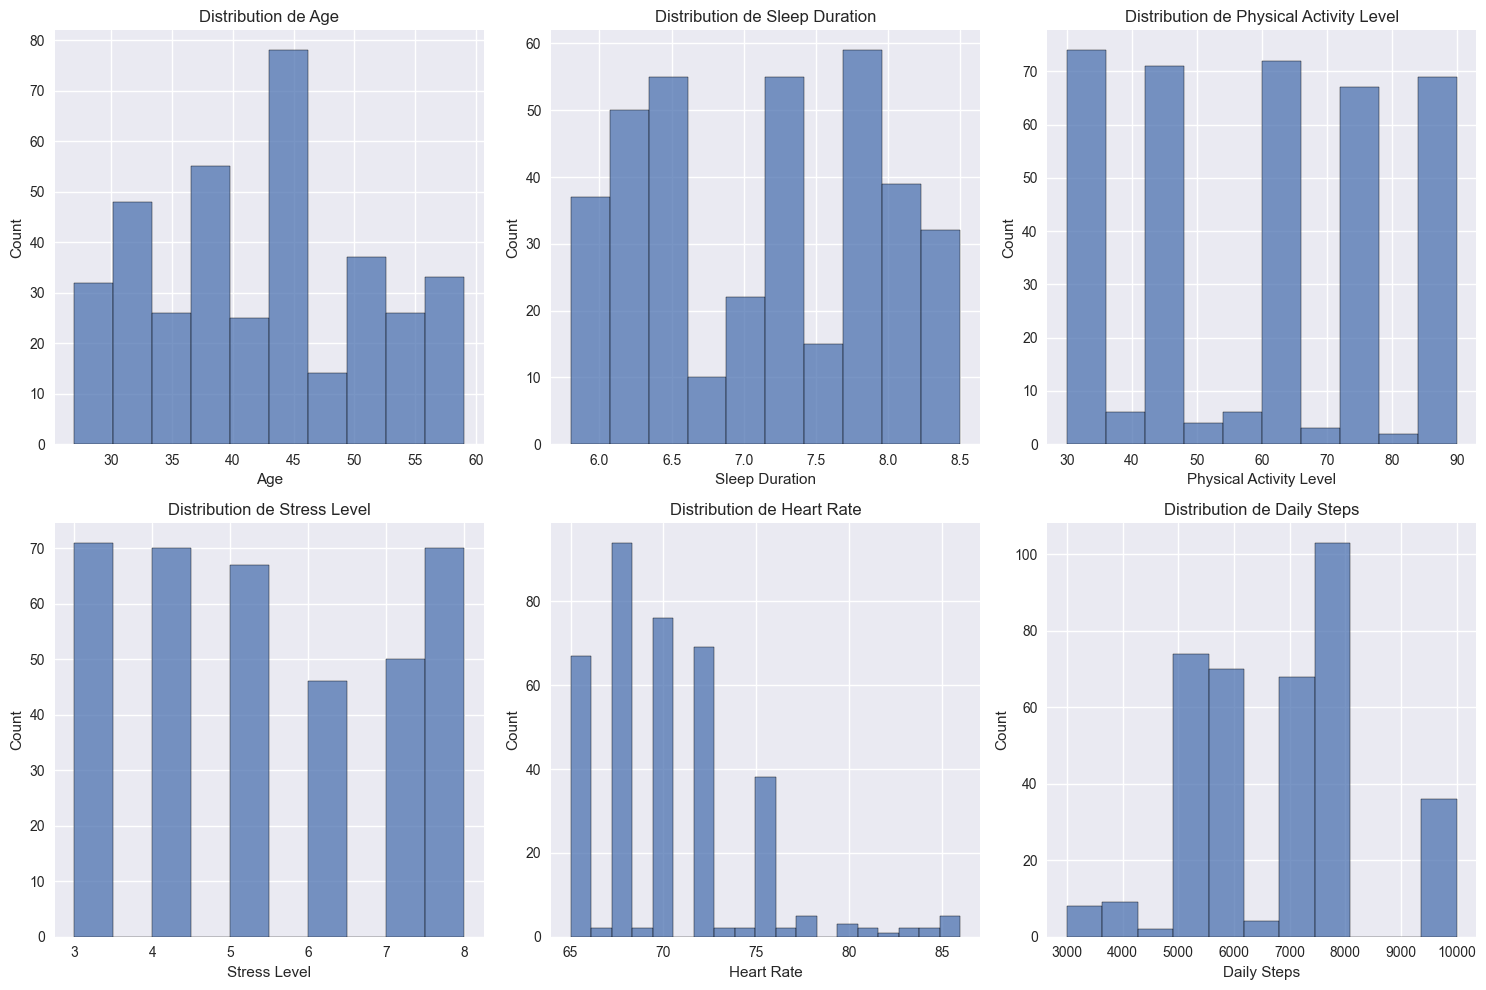

In [25]:
# Distribution de la qualité du sommeil
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Quality of Sleep', bins=20)
plt.title('Distribution de la Qualité du Sommeil')
plt.xlabel('Qualité du Sommeil')
plt.ylabel('Fréquence')
plt.show()

# Distribution des variables numériques principales
numeric_cols = ['Age', 'Sleep Duration', 'Physical Activity Level', 
                'Stress Level', 'Heart Rate', 'Daily Steps']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    row = i // 3
    col_idx = i % 3
    sns.histplot(data=df, x=col, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribution de {col}')
plt.tight_layout()
plt.show()

## 6. Analyse des corrélations

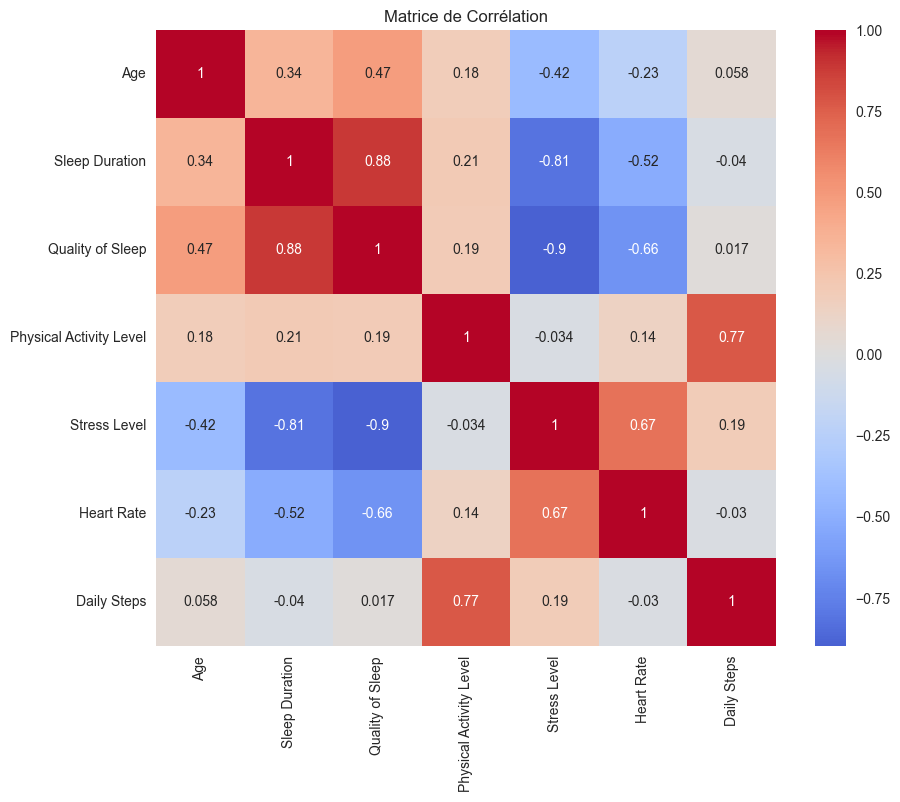

In [26]:
# Matrice de corrélation
numeric_df = df[['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 
                 'Stress Level', 'Heart Rate', 'Daily Steps']]
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de Corrélation')
plt.show()

## 7. Prétraitement des données

In [27]:
# Conversion des variables catégorielles
df['Gender_num'] = (df['Gender'] == 'Male').astype(int)
df['Blood_Pressure_num'] = (df['Blood Pressure'] == 'High').astype(int)

# Sélection des features
X = df[['Age', 'Gender_num', 'Sleep Duration', 'Physical Activity Level', 
        'Stress Level', 'Heart Rate', 'Daily Steps', 'Blood_Pressure_num']]
y = df['Quality of Sleep']

# Division en ensembles d'entraînement et de test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection
selector = SelectKBest(score_func=f_regression, k=4)
X_temp_selected = selector.fit_transform(X_temp, y_temp)
selected_features = X.columns[selector.get_support()].tolist()
X_test_selected = selector.transform(X_test)

print("Features sélectionnées:", selected_features)

# Standardisation
scaler = StandardScaler()
X_temp_scaled = scaler.fit_transform(X_temp_selected)
X_test_scaled = scaler.transform(X_test_selected)

Features sélectionnées: ['Age', 'Sleep Duration', 'Stress Level', 'Heart Rate']


## 8. Analyse des features sélectionnées

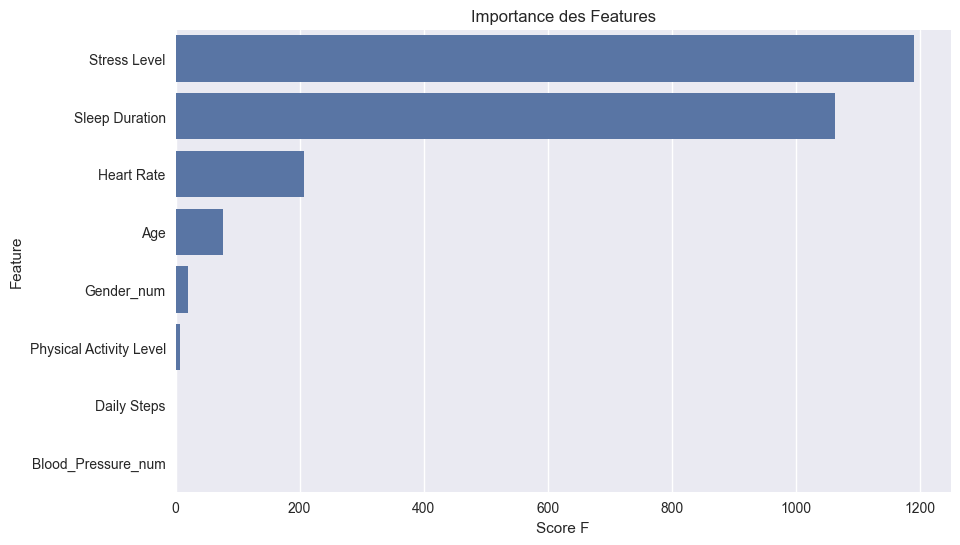

In [28]:
# Score d'importance des features
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
})
feature_scores = feature_scores.sort_values('Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_scores, x='Score', y='Feature')
plt.title('Importance des Features')
plt.xlabel('Score F')
plt.show()

## 9. Sauvegarde des données prétraitées

In [29]:
# Créer le répertoire processed_data s'il n'existe pas
output_dir = os.path.join(project_root, 'data', 'processed')
os.makedirs(output_dir, exist_ok=True)

# Sauvegarder les données prétraitées
np.save(os.path.join(output_dir, 'X_train.npy'), X_temp_scaled)
np.save(os.path.join(output_dir, 'X_test.npy'), X_test_scaled)
np.save(os.path.join(output_dir, 'y_train.npy'), y_temp)
np.save(os.path.join(output_dir, 'y_test.npy'), y_test)

# Sauvegarder les métadonnées
preprocessing_metadata = {
    'selected_features': selected_features,
    'feature_scores': feature_scores.to_dict(),
    'scaler_mean': scaler.mean_.tolist(),
    'scaler_scale': scaler.scale_.tolist(),
    'dataset_shape': {
        'total_samples': len(X),
        'train_samples': len(X_temp),
        'test_samples': len(X_test),
        'n_features': len(selected_features)
    }
}

import json
with open(os.path.join(output_dir, 'preprocessing_metadata.json'), 'w') as f:
    json.dump(preprocessing_metadata, f, indent=4)

print("Données prétraitées et métadonnées sauvegardées dans:", output_dir)

Données prétraitées et métadonnées sauvegardées dans: /Users/ines/Desktop/sleep_health_project/data/processed
